In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# HELPER FUNCTIONS
def display(img):
    plt.figure(figsize=(12, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def display_two(img1, img2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(img1)
    ax1.axis('off')
    
    ax2.imshow(img2)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

def downscale_image(image, factor):
    """
    Downscale an image by factor using linear interpolation.
    
    Args:
        image: Input image array
    
    Returns:
        numpy.ndarray: Downscaled image array
    """
    height, width = image.shape[:2]
    new_width = width // factor
    new_height = height // factor
    return cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

def load_image(image_path):
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    return image_rgb

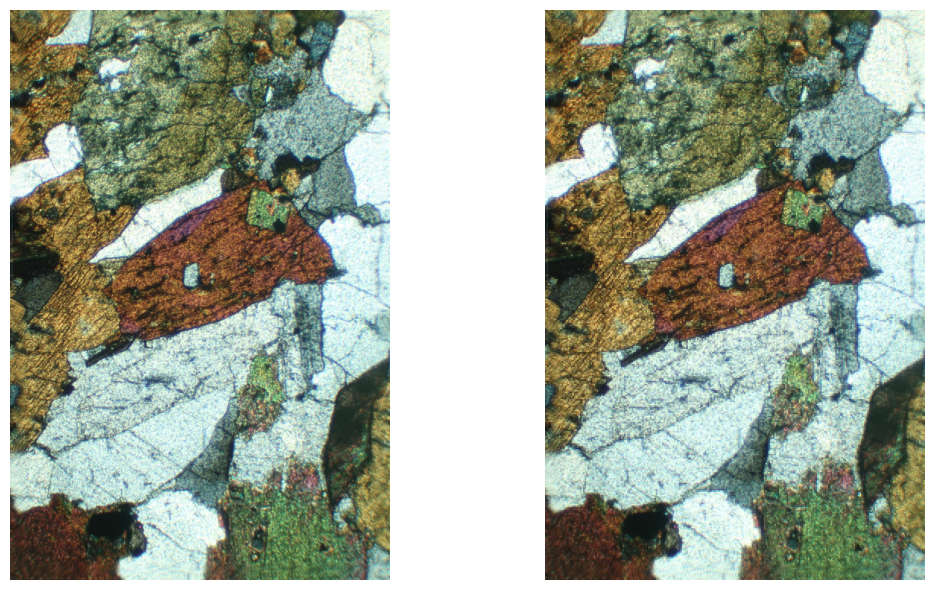

(1500, 1000, 3)


In [3]:
# Load the images and downscale
composite = load_image('./thin-sections/w3_3/w3_3_composite.jpg')
composite_small = downscale_image(composite, 2)
composite_tiny = downscale_image(composite, 8)
display_two(composite, composite_tiny)
print(composite_small.shape)

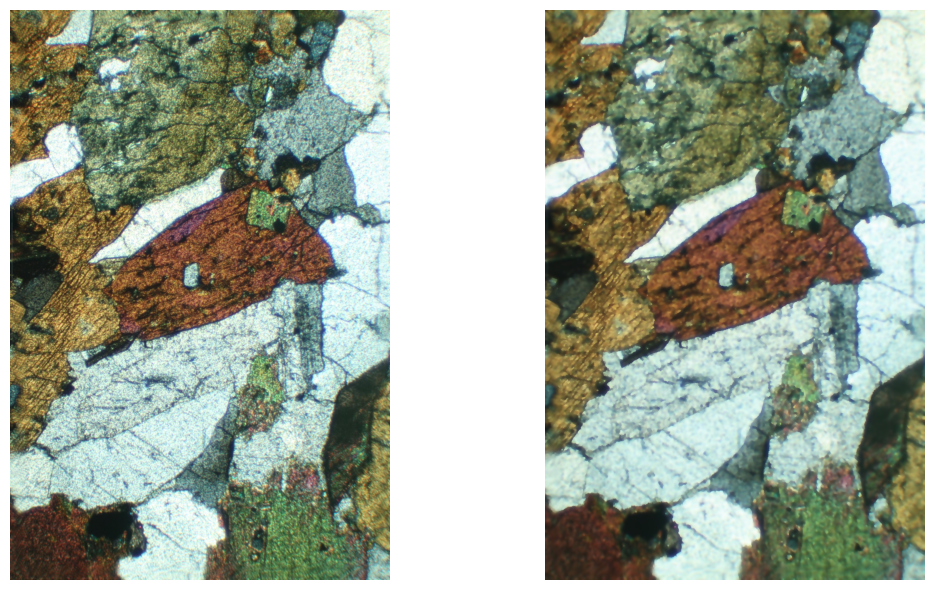

In [66]:
# Possible experiment: Blur the image than identify edgers, then remove the edges from the image
composite_small_blur = cv2.bilateralFilter(composite_small, d=9, sigmaColor=75, sigmaSpace=75)
composite_small_blur = cv2.bilateralFilter(composite_small_blur, d=9, sigmaColor=75, sigmaSpace=75)
display_two(composite_small, composite_small_blur)

composite_small_edges = cv2.Canny(composite_small_blur, 100, 200)

In [4]:
def extract_pixel_features(image):
    """
    Preprocesses an image by extracting pixel values and their coordinates.
    
    Parameters:
    image (numpy.ndarray): Input image of shape (h, w, 3) for RGB
    
    Returns:
    numpy.ndarray: Array of shape (h*w, 5) containing:
        - RGB values (3 columns)
        - x,y coordinates (2 columns)
    """
    h, w, c = image.shape
    
    # Reshape image to 2D array of pixels
    pixels = image.reshape(-1, 3)
    
    # Get coordinates for each pixel
    y_coords, x_coords = np.indices((h, w))
    coords = np.column_stack((x_coords.ravel(), y_coords.ravel()))
    
    # Stack RGB values and coordinates
    features = np.column_stack((pixels, coords))
    
    return features

pixels_with_dark = extract_pixel_features(composite_small)
print(pixels_with_dark.shape)
pixels = pixels_with_dark # Uncomment to not remove dark pixels

(1500000, 5)


In [77]:
def remove_dark_pixels(features, threshold, method='average'):
    """
    Removes pixels darker than the specified threshold using various darkness calculation methods.
    
    Parameters:
    features: Output from extract_pixel_features (array with RGB values in first 3 columns)
    threshold: Darkness threshold (0-255), pixels darker than this will be removed
    method: String specifying darkness calculation method:
           'average' - simple RGB average
           'weighted' - weighted RGB based on human perception
           'maximum' - maximum RGB component
    
    Returns:
    numpy.ndarray: Filtered features array
    """
    rgb_values = features[:, :3]
    
    if method == 'average':
        # Simple average of RGB values
        darkness_scores = np.mean(rgb_values, axis=1)
    elif method == 'weighted':
        # Weighted RGB based on human perception
        # These weights approximate human perception of brightness
        weights = np.array([0.299, 0.587, 0.114])
        darkness_scores = np.dot(rgb_values, weights)
    elif method == 'maximum':
        # Maximum RGB component (most conservative approach)
        darkness_scores = np.max(rgb_values, axis=1)
    else:
        raise ValueError("Method must be 'average', 'weighted', or 'maximum'")
    
    # Keep pixels brighter than threshold
    mask = darkness_scores > threshold
    filtered_features = features[mask]
    
    return filtered_features

pixels = remove_dark_pixels(pixels_with_dark, 80)
print(pixels.shape)

(1094520, 5)


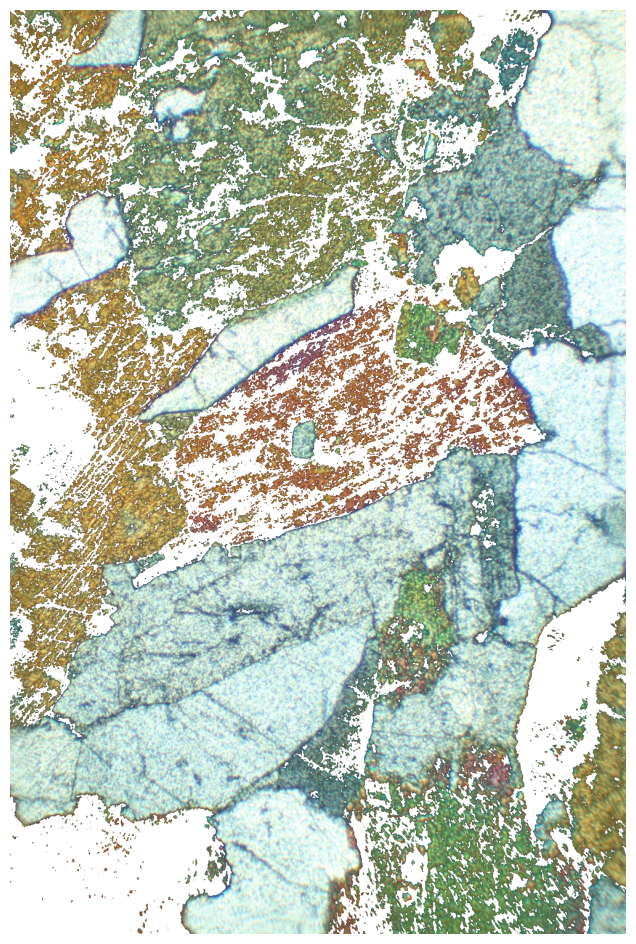

In [78]:
def visualize_removed_pixels(features, filtered_features, original_shape):
    """
    Reconstructs image with removed pixels shown in white.
    
    Parameters:
    features: Original features from extract_pixel_features
    filtered_features: Output from remove_dark_pixels
    original_shape: Original image shape (h, w, c)
    
    Returns:
    numpy.ndarray: Reconstructed image with removed pixels in white, shape (h, w, 3)
    """
    # Initialize white image
    h, w = original_shape[:2]
    reconstructed = np.full((h * w, 3), 255, dtype=np.uint8)
    
    # Get coordinates from filtered features
    filtered_coords = filtered_features[:, 3:5].astype(int)
    
    # Convert coordinates to indices
    indices = filtered_coords[:, 1] * w + filtered_coords[:, 0]
    
    # Put back the kept pixels
    reconstructed[indices] = filtered_features[:, :3].astype(np.uint8)
    
    # Reshape back to original image shape
    return reconstructed.reshape(original_shape)

reconstructed_composite_small = visualize_removed_pixels(pixels_with_dark, pixels, composite_small.shape)
display(reconstructed_composite_small)

In [5]:
from sklearn.cluster import KMeans

def kmeans_segment(features, n_clusters=5, spatial_weight=1.0, random_state=42):
    """
    Segments preprocessed image features using K-means clustering.
    
    Parameters:
    features: Array from extract_pixel_features, with dark pixels removed
             Shape: (n_pixels, 5) where each row is [R,G,B,x,y]
    n_clusters: Number of segments to create (default: 5)
    spatial_weight: Weight for spatial features (x,y) vs color (RGB)
                   Higher values make spatial location more important
                   Lower values make color more important
    random_state: Random seed for reproducibility
    
    Returns:
    labels: Cluster assignments for each pixel
    centroids: Final cluster centers
    """
    # Normalize features to [0,1] range
    rgb_features = features[:, :3] / 255.0  # Scale RGB to [0,1]
    
    # Get spatial features and normalize by image dimensions
    xy_features = features[:, 3:5]
    xy_max = np.max(xy_features, axis=0)
    xy_normalized = xy_features / xy_max
    
    # Combine features with spatial weight
    combined_features = np.column_stack([
        rgb_features,
        xy_normalized * spatial_weight
    ])
    
    # Apply K-means
    kmeans = KMeans(
        n_clusters=n_clusters,
        init='k-means++',  # Smart initialization
        n_init=10,         # Number of initializations to try
        max_iter=300,      # Maximum iterations per initialization
        random_state=random_state
    )
    
    # Fit and get labels
    labels = kmeans.fit_predict(combined_features)
    
    return labels, kmeans.cluster_centers_

# Apply K-means segmentation
n_clusters = 12
labels, centroids = kmeans_segment(
    pixels, 
    n_clusters=n_clusters,
    spatial_weight=1
)

Optimal number of clusters: 3


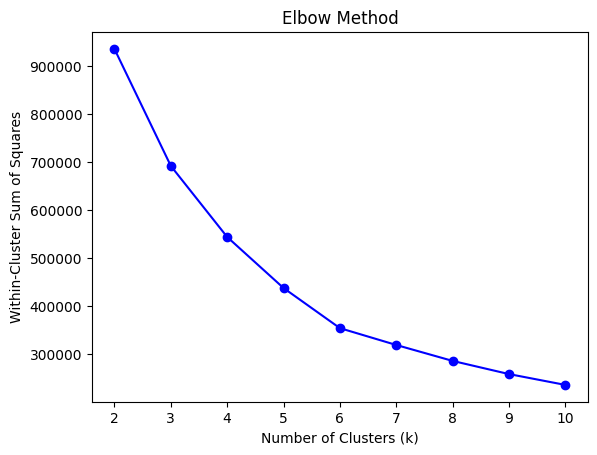

In [95]:
def find_optimal_k(features, k_range=range(2, 11), spatial_weight=1.0, random_state=42):
    """
    Finds optimal k using elbow method, building on existing kmeans_segment.
    
    Parameters:
    features: Array from extract_pixel_features, with dark pixels removed
    k_range: Range of k values to try (default: 2 to 10)
    spatial_weight: Weight for spatial features vs color
    random_state: Random seed for reproducibility
    
    Returns:
    optimal_k: Optimal number of clusters
    wcss_values: List of WCSS values for each k
    """
    wcss_values = []
    
    # Calculate WCSS for each k
    for k in k_range:
        print(f'K-Means for k = {k}')
        labels, centroids = kmeans_segment(
            features, 
            n_clusters=k,
            spatial_weight=spatial_weight,
            random_state=random_state
        )
        
        # Calculate WCSS using the normalized features (same as in kmeans_segment)
        rgb_features = features[:, :3] / 255.0
        xy_features = features[:, 3:5]
        xy_max = np.max(xy_features, axis=0)
        xy_normalized = xy_features / xy_max
        
        combined_features = np.column_stack([
            rgb_features,
            xy_normalized * spatial_weight
        ])
        
        # Calculate distance from each point to its centroid
        distances = np.sum((combined_features - centroids[labels])**2, axis=1)
        wcss = np.sum(distances)
        wcss_values.append(wcss)
    
    # Find elbow point (largest change in slope)
    differences = np.diff(wcss_values)
    optimal_k = k_range[np.argmin(differences) + 1]
    
    return optimal_k, wcss_values

spatial_weight = 2

k_range = range(2, 11)  # Try k from 2 to 10
optimal_k, wcss_values = find_optimal_k(
    pixels,
    k_range=k_range,
    spatial_weight=spatial_weight
)

print(f"Optimal number of clusters: {optimal_k}")

# Visualize elbow curve
plt.plot(list(k_range), wcss_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method')
plt.show()

# Use optimal k for final segmentation
labels, centroids = kmeans_segment(
    pixels,
    n_clusters=optimal_k,
    spatial_weight=spatial_weight
)

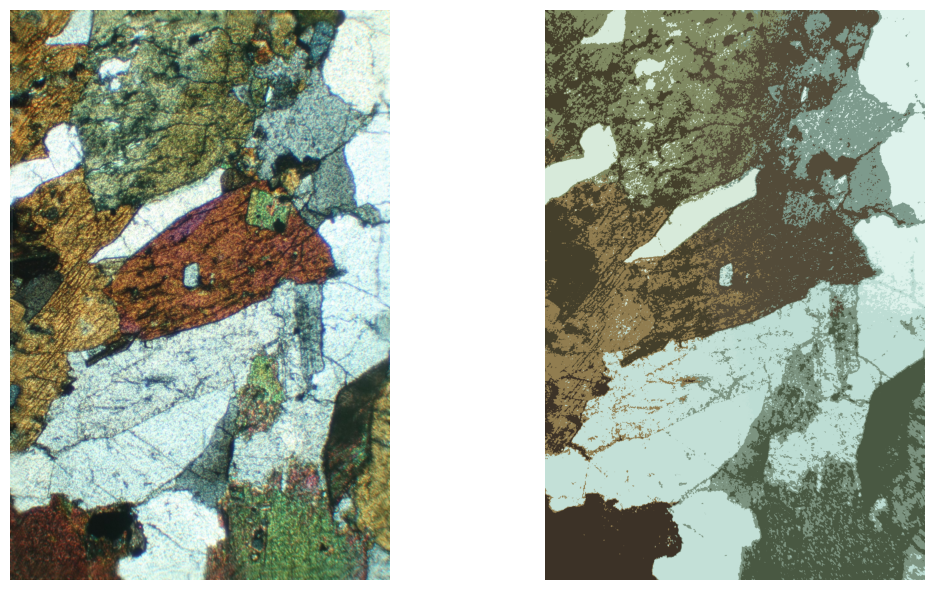

In [6]:
def visualize_segments(features, labels, centroids, original_shape, spatial_weight):
    """
    Creates a visualization of the segments using centroid colors.
    
    Parameters:
    features: Original feature array with pixel coordinates
    labels: Cluster labels from kmeans_segment
    centroids: Cluster centroids from kmeans_segment
    original_shape: Shape of original image (h, w, 3)
    spatial_weight: Spatial weight used in clustering
    
    Returns:
    numpy.ndarray: Colored segmentation map using centroid colors
    """
    # Extract RGB values from centroids (first 3 dimensions)
    centroid_colors = centroids[:, :3] * 255  # Scale back to 0-255 range
    centroid_colors = centroid_colors.astype(np.uint8)
    
    # Initialize white image
    h, w = original_shape[:2]
    segmented = np.full((h * w, 3), 255, dtype=np.uint8)
    
    # Get coordinates from features
    coords = features[:, 3:5].astype(int)
    
    # Convert coordinates to indices
    indices = coords[:, 1] * w + coords[:, 0]
    
    # Assign centroid colors based on labels
    segmented[indices] = centroid_colors[labels]
    
    # Reshape back to original image shape
    return segmented.reshape(original_shape)

# Visualize results
segmentation_map = visualize_segments(
    pixels,
    labels,
    centroids,
    composite_small.shape,
    n_clusters
)

display_two(composite_small, segmentation_map)

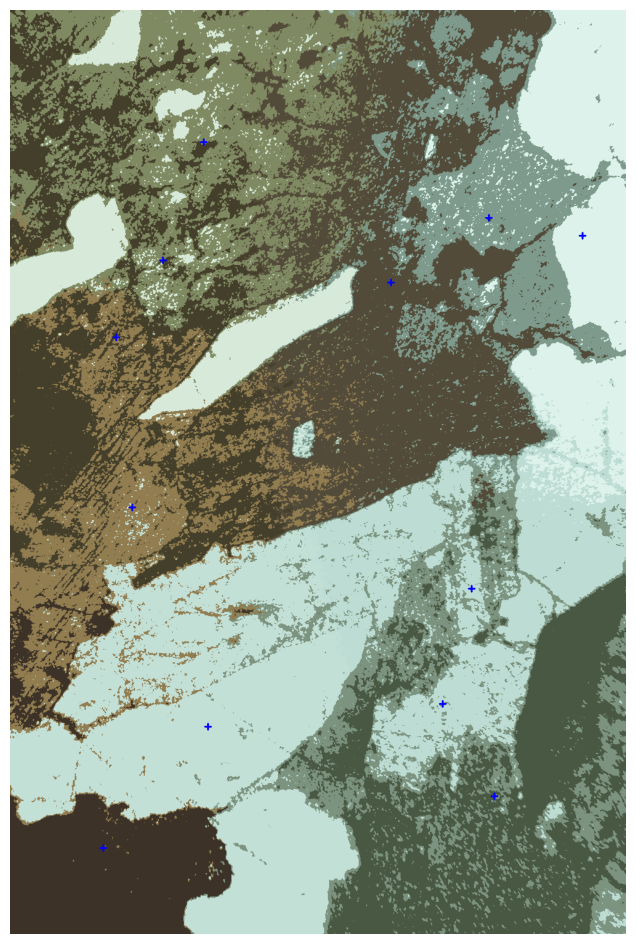

In [104]:
def weiszfeld_step(points, weights=None, eps=1e-8):
    """
    Single iteration of Weiszfeld's algorithm to find geometric median.
    
    Parameters:
    points: Array of points (n_points, n_dimensions)
    weights: Optional weights for each point
    eps: Small number to prevent division by zero
    
    Returns:
    numpy.ndarray: Updated estimate of geometric median
    """
    if weights is None:
        weights = np.ones(len(points))
        
    # Start with weighted mean as initial estimate
    if len(points) == 0:
        return None
    
    y = np.average(points, weights=weights, axis=0)
    
    # Calculate distances to current estimate
    distances = np.linalg.norm(points - y, axis=1)
    
    # Update weights based on distances (avoid division by zero)
    w = weights / (distances + eps)
    
    # New estimate
    new_y = np.average(points, weights=w, axis=0)
    
    return new_y

def find_geometric_median(points, weights=None, max_iter=100, tol=1e-7):
    """
    Find geometric median using Weiszfeld's algorithm.
    
    Parameters:
    points: Array of points (n_points, n_dimensions)
    weights: Optional weights for each point
    max_iter: Maximum iterations
    tol: Convergence tolerance
    
    Returns:
    numpy.ndarray: Geometric median
    """
    if len(points) == 0:
        return None
        
    # Initialize with weighted mean
    y = np.average(points, weights=weights, axis=0)
    
    for _ in range(max_iter):
        new_y = weiszfeld_step(points, weights)
        
        # Check convergence
        if np.linalg.norm(new_y - y) < tol:
            break
            
        y = new_y
    
    return y

def find_grain_centers(features, labels, n_clusters):
    """
    Find center points for each grain using Weiszfeld's algorithm.
    
    Parameters:
    features: Array from extract_pixel_features
    labels: Cluster labels from kmeans_segment
    n_clusters: Number of clusters
    
    Returns:
    numpy.ndarray: Center points for each grain (n_clusters, 2)
    """
    centers = []
    
    for i in range(n_clusters):
        # Get points belonging to this cluster
        mask = labels == i
        cluster_points = features[mask]
        
        # Extract spatial coordinates
        spatial_coords = cluster_points[:, 3:5]
        
        # Get RGB values for possible weighting
        rgb_values = cluster_points[:, :3]
        
        # Optional: Use color similarity as weights
        # weights = np.mean(rgb_values, axis=1) / 255.0
        
        # Find geometric median of spatial coordinates
        center = find_geometric_median(spatial_coords)
        
        if center is not None:
            centers.append(center)
    
    return np.array(centers)

# Example usage:

# After running kmeans_segment:
grain_centers = find_grain_centers(pixels, labels, n_clusters)

# Visualize centers on segmented image
def visualize_centers(segmented_image, centers):
    vis_img = segmented_image.copy()
    
    # Draw centers
    for center in centers:
        x, y = center.astype(int)
        # Draw crosshair or circle at center
        cv2.drawMarker(vis_img, 
                      (x, y), 
                      (0, 0, 255),  # Red color
                      cv2.MARKER_CROSS, 
                      markerSize=10, 
                      thickness=2)
    
    return vis_img

vis_img = visualize_centers(segmentation_map, grain_centers)
display(vis_img)
